# Выбор локации для скважины

## Цель проекта

Задача проекта - разработать алгоритм выбора оптимального месторождения для достижения максимальной прибыли при установленном уровне риска. Алгоритм будет обучаться на основании данных о пробах из трех регионов, где измерили качество нефти и объём её запасов. Необходимо оценить возможную прибыль с вероятностью 95%, а также вероятность убытков при разработке месторождений.

Также установлены следующие экономические ограничения:
* Бюджет на разработку месторождения в регионе составляет 10 млрд руб.;
* Разведка проводится на 500 скважинах;
* Максимальное количество скважин к разработке - 200;
* Баррель нефти стоит 450 руб;
* Предельно допустимый шанс убытков - 2,5%.

Для реализации поставленной задачи необходимо:
* Проанализировать исходные данные и подготовить их для дальнейшей работы;
* Составить модели для каждого из регионов, предсказывающих уровень запасов в скважине в зависимости от ее характеристик;
* На основании полученных моделей получить оценки запасов месторождений;
* С помощью техники *bootstrap* выявить доверителньый интерваал прибылей в регионах, а также оценить вероятность убытков при разработке. 

In [1]:
# Импорты используемых библиотек:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from numpy.random import RandomState

# Подготовка выборок:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Регрессор и метрики качества:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

### Первичный обзор

Для анализа представлены датасеты для трех регионов. Регион 0:

In [2]:
# Данные региона 0:
try:
    df_reg0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    df_reg0 = pd.read_csv('datasets/geo_data/geo_data_0.csv')

df_reg0.info()
df_reg0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


В датасете для региона 0 находится 100 тыс. объектов. Датасет содержит информацию об `id` скважины (не участвует в моделировании), трех параметрах скважины (`f0, f1, f2`) и оцененных запасах в тыс. баррелей. Пропуски в данных отсутствуют.

Регион 1:

In [3]:
# Данные региона 1:
try:
    df_reg1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df_reg1 = pd.read_csv('datasets/geo_data/geo_data_1.csv')

df_reg1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Аналогично, в датасете содержатся 100 тыс. объектов с тем же набором признаков. Пропуски в данных отсутствуют.

Регион 2:

In [4]:
# Данные региона 2:
try:
    df_reg2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_reg2 = pd.read_csv('datasets/geo_data/geo_data_2.csv')

df_reg2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Как и в случае с регионами 0 и 1, датасет содержит 100 тыс. наблюдений, Данные не имеют пропусков. 

Теперь рассмотрим распределения признаков в разных регионах.

### Распределение признаков

Для удобства введем функции для визуализации и описательных статистик для всех трех регионов сразу:

In [5]:
# Для удобства поместим данные в список, где индексу соответствует номер региона:
dfs = [df_reg0, df_reg1, df_reg2]

# Функция для визуализации распределений
def distributions(feature, title='', xlabel=''):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)

    for i in range(0,3):
        sbn.histplot(dfs[i][feature], ax = axes[i])
        axes[i].set_title('Регион '+str(i))
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[1].set_xlabel(xlabel)
    axes[0].set_ylabel('Частота в ед.')

# Функция для дескриптивных статистик:
def descr_stats(feature):
    
    visual_tablе = pd.DataFrame(index = df_reg0['product'].describe().index)
    for i in range(3):
        visual_tablе['Регион '+str(i)] = dfs[i][feature].describe()

    return visual_tablе.drop(index='count')

**Целевой признак**

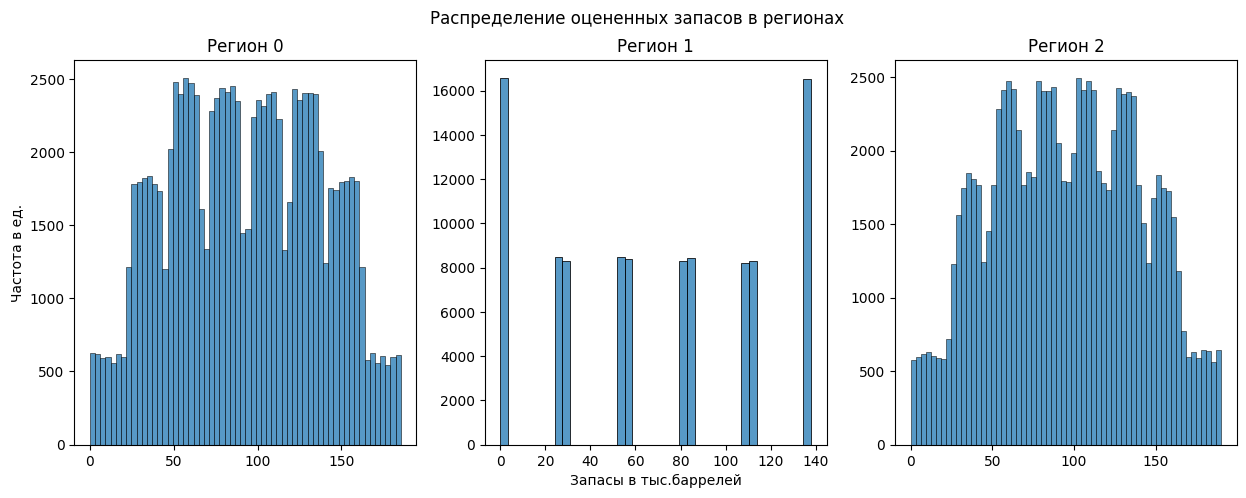

In [6]:
distributions('product', 
             'Распределение оцененных запасов в регионах',
             'Запасы в тыс.баррелей')

In [7]:
# Описательная статистика:
display(descr_stats('product'))

,Регион 0,Регион 1,Регион 2
mean,92.500000,68.825000,95.000000
std,44.288691,45.944423,44.749921
min,0.000000,0.000000,0.000000
25%,56.497507,26.953261,59.450441
50%,91.849972,57.085625,94.925613
75%,128.564089,107.813044,130.595027
max,185.364347,137.945408,190.029838


<a id = 'c1'></a>
Заметно, что распределения целевого признака в регионах 0 и 2 похожи как по основным статистикам (среднее, квантили, стандартное отклонение), так и по форме (6 пиков). Распределение признака в регионе 1 существенно отличается: в данных всего 12 уникальных значений, что обеспечивает столбчатую форму диаграммы. При этом среднее значение меньше, чем для регионов 0 и 1 на ок. 20-25%, медиана - на ок. 40%.

**Признак F0**

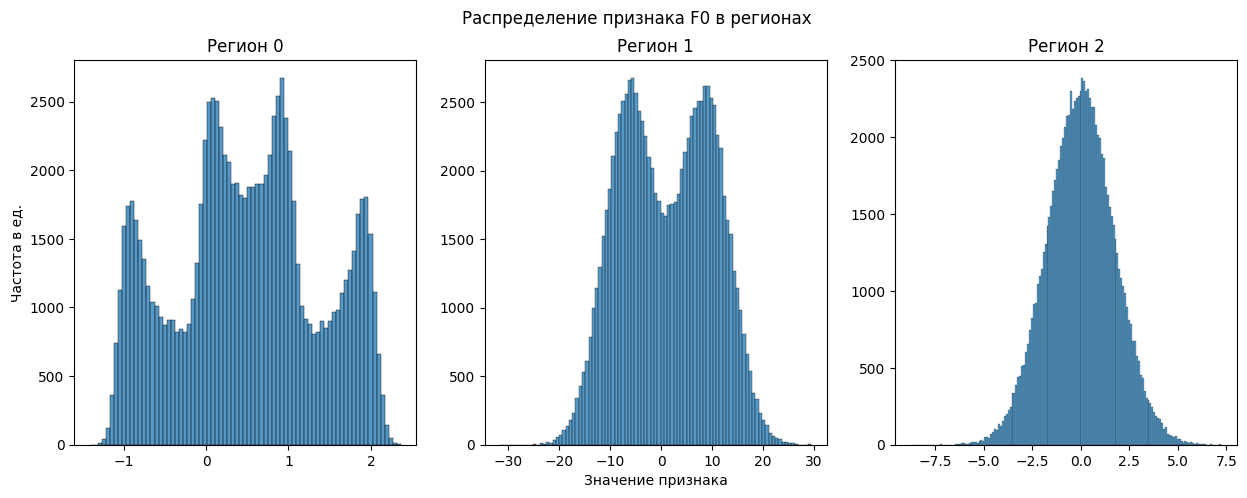

In [8]:
distributions('f0',
             'Распределение признака F0 в регионах',
             'Значение признака')

In [9]:
# Описательная статистика:
display(descr_stats('f0'))

,Регион 0,Регион 1,Регион 2
mean,0.500419,1.141296,0.002023
std,0.871832,8.965932,1.732045
min,-1.408605,-31.609576,-8.760004
25%,-0.072580,-6.298551,-1.162288
50%,0.502360,1.153055,0.009424
75%,1.073581,8.621015,1.158535
max,2.362331,29.421755,7.238262


Во всех трех регионах признак имеет как положительные, так и отрицательные значения. Для распределений во всех регионах характерна симметричность (неточная, но все же заметная). При этом форма распределений меняется от региона к региону:
* наименьший разброс значений характерен для региона 0 (от -1.4 до 2.4), наибольший - для региона 1 (от -31.6 до 29.4).
* распределение для региона 0 имеет 4 пика, для региона 1 - 2 пика, для региона 2 - 1 пик.

**Признак F1**

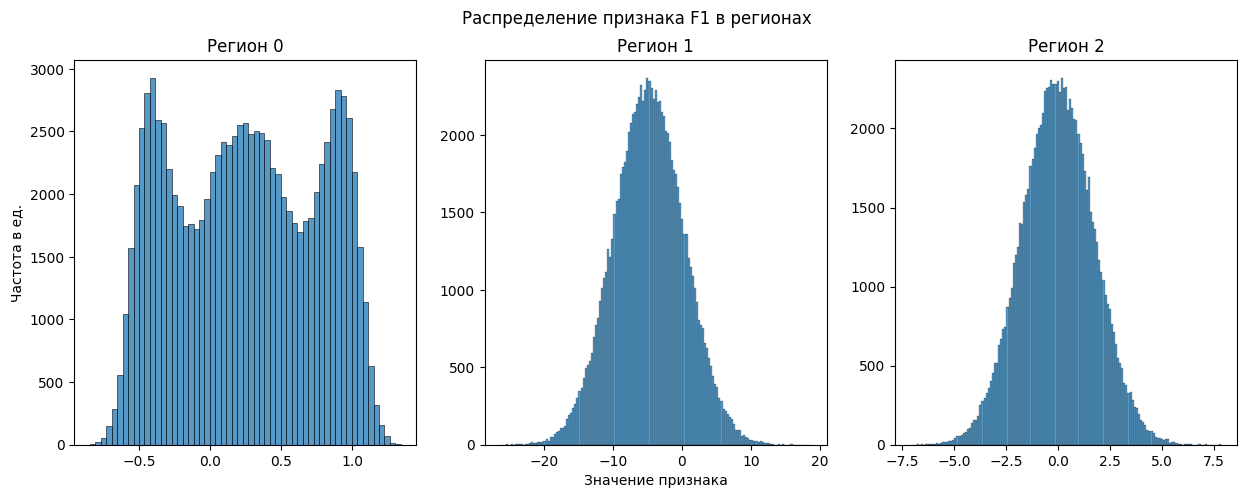

In [10]:
# Гистограммы для трех регионов:
distributions('f1',
             'Распределение признака F1 в регионах',
             'Значение признака')

In [11]:
# Описательная статистика:
display(descr_stats('f1'))

,Регион 0,Регион 1,Регион 2
mean,0.250143,-4.796579,-0.002081
std,0.504433,5.119872,1.730417
min,-0.848218,-26.358598,-7.084020
25%,-0.200881,-8.267985,-1.174820
50%,0.250252,-4.813172,-0.009482
75%,0.700646,-1.332816,1.163678
max,1.343769,18.734063,7.844801


Как и в случае с признаком F0, вариативность и формы распределений признака F1 разнятся от региона к региону:
* Наибольший разброс характерен для региона 1 (от -26.4 до 18.7), наименьший - для региона 0 (от -0.8 до 1.3).
* Распределение для региона 0 имеет 3 пика, для прочих регионов - один.

**Признак F2**

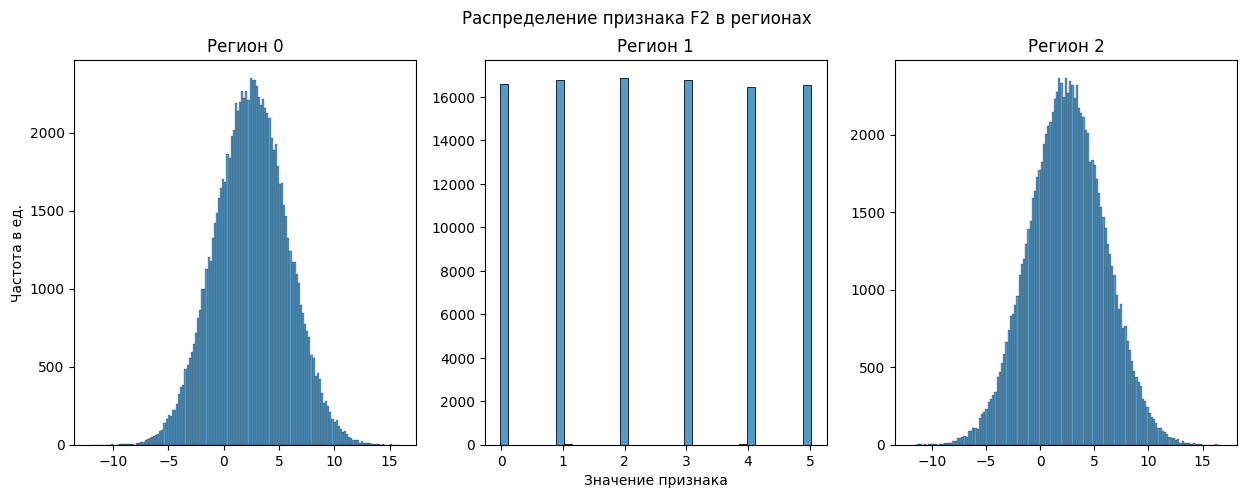

In [12]:
# Гистограммы для трех регионов:
distributions('f2',
             'Распределение признака F2 в регионах',
             'Значение признака')

In [13]:
# Описательная статистика:
display(descr_stats('f2'))

,Регион 0,Регион 1,Регион 2
mean,2.502647,2.494541,2.495128
std,3.248248,1.703572,3.473445
min,-12.088328,-0.018144,-11.970335
25%,0.287748,1.000021,0.130359
50%,2.515969,2.011479,2.484236
75%,4.715088,3.999904,4.858794
max,16.003790,5.019721,16.739402


Поведение признака F2 в большей степени напоминает поведение целевого признака в зависимости от регионов:
* Распределения для регионов 0 и 2 похожи как с точки зрения описательных статистик (среднее, стандартное отклонение, квантили), так и формой (хотя формы распределений целевого признака и признака f2 в рамках одного региона различны).
* Распределение признака f2 для региона 1 "скученное", т.е. все значения распределены по нескольким относительно узким интервалам.

Возможно, дисперсия этого признака вносит больший вклад в объяснение вариации целевого признака, нежели признаки F0 и F1.

### Вывод

Исходные данные представлены тремя датасетами по 100 тыс. объектов для каждого из трех регионов. Пропуски в данных отсутствуют, все признаки - количественные.

Распределения объясняющих признаков и целевого признака в регионах обладают разной вариативностью, в связи с чем необходимо стандартизировать данные для улучшения качества моделей.

## Обучение и проверка моделей

### Подготовка выборок

Разобъем исходные датасеты на обучающие и валидационные выборки в соотношении 75% : 25%.

In [14]:
features_train = []
target_train = []
features_valid = []
target_valid = []

for i in range(3):
    # Разделяем признаки и целевой признак:
    X = dfs[i].drop(columns=['id', 'product'])
    y = dfs[i]['product']

    # Разделяем на обучающие и валидационные выборки:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size = 0.25, 
                                                          random_state = 1104)
    features_train.append(X_train)
    features_valid.append(X_valid)
    target_train.append(y_train)
    target_valid.append(y_valid)
    print(f'Размер обучающей выборки для региона {i}: {X_train.shape[0]}.')

Размер обучающей выборки для региона 0: 75000.
Размер обучающей выборки для региона 1: 75000.
Размер обучающей выборки для региона 2: 75000.


Теперь стандартизируем признаки для улучшения точности моделей:

In [15]:
for i in range(3):
    scaler = StandardScaler()
    scaler.fit(features_train[i])
    features_train[i] = scaler.transform(features_train[i])
    features_valid[i] = scaler.transform(features_valid[i])

### Обучение моделей

Обучим модели линейной регрессии для каждых из трех регионов и найдем метрики на валидационных выборках:

In [16]:
# Заготовки для хранения результатов:
models = []
predictions = []
mses = []
r2s = []
# Обучаем модели для трех регионов:
for i in range(3):
    model = LinearRegression()
    model.fit(features_train[i], target_train[i]) # обучение для i-того региона
    models.append(model)
    # Находим предсказания и метрики на валидационной выборке:
    predict = model.predict(features_valid[i])
    predictions.append(predict)
    mse = mean_squared_error(target_valid[i], predict)
    r2 = model.score(features_valid[i], target_valid[i])
    mses.append(mse)                             # сохраняем метрики для i-того региона
    r2s.append(r2)

    print('Средний запас 1 скважины в регионе {0}: {1: .2f} тыс. баррелей; RMSE: {2: .2f}: R-squared: {3: .4f}.'.
     format(i, predict.mean(), mse**0.5, r2)
     )

Средний запас 1 скважины в регионе 0:  92.25 тыс. баррелей; RMSE:  37.81: R-squared:  0.2672.
Средний запас 1 скважины в регионе 1:  68.67 тыс. баррелей; RMSE:  0.89: R-squared:  0.9996.
Средний запас 1 скважины в регионе 2:  95.19 тыс. баррелей; RMSE:  40.12: R-squared:  0.1998.


### Вывод

Средний уровень запаса, согласно предсказаниям моделей, не слишком отличается от среднего по исходным датасетам ([см. здесь](#c1)). Наибольшее среднее значение в регионе 2 (ок. 95 тыс. баррелей), затем следует регион 0 (ок. 92 тыс. баррелей). Наименьшее среднее значение запасов одной скважины в регионе 1 - ок. 68 тыс. баррелей. 

Однако значения среднеквадратичной ошибки ранжируются также - наибольшее значение у модели для региона 2 (ок. 40 тыс. баррелей), затем регион 0 (ок. 37 тыс. баррелей). При этом RMSE для модели региона 1 не превышает 1 тыс. баррелей. Модель для региона 1 также объясняет наибольшую долю дисперсии целевого признака (ок. 42% против ок. 27% для региона 0 и 20% для региона 2).

Таким образом, регионы 0 и 2 представляются, с одной стороны, более богатыми за счет большего среднего значения запасов в одной скважине, но и более рискованными за счет большего значения ошибки. Регион 1, напротив, кажется менее обильным с точки зрения запасов, но и менее рисковым. 

## Подготовка к расчёту прибыли

### Минимальный уровень запасов для окупаемости

Рассчитаем средний минимальный уровень запасов в скважине, достаточный для окупаемости разработки месторождений:

In [17]:
# Исходные данные задачи:
N_INVESTIGATION = 500 # число разведанных скважин в регионе
N_DEVELOPMENT = 200 # число скважин для дальнейшей разработки в регионе
BUDGET = 10000000 # общий бюджет на разработку в регионе (в тыс.руб.)
PRICE = 450 # стоимость одного барреля (в руб.)
ACCEPTED_LOSS_PROBA =0.025 # предельно допустимая вероятность убытков в регионе

In [18]:
# Рассчитаем минимальный средний уровень запасов 1 скважины, необходимый для окупаемости:
MIN_AVG_RESERVE = BUDGET / PRICE / N_DEVELOPMENT # доход от продажи со всех скважин в разработке равен бюджету на разработку
print(f'Минимальный средний запас 1 скважины для окупаемости разработки: {MIN_AVG_RESERVE:.3f} тыс.баррелей.')

Минимальный средний запас 1 скважины для окупаемости разработки: 111.111 тыс.баррелей.


Минимальный средний запас для окупаемости выше, чем средние значения запасов во всех регионах. Тем не менее, по условиям задачи отбираются лучшие месторождения из попавших в выборку, соответственно, среднее значение в отрыве от стандартного отклонения непоказательно. Т.е., хотя средния значения для регионов 0 и 2 выше, чем для региона 1, вероятность получить для них значения ниже среднего также выше за счет большего разброса. 

### Подготовка данных

Прежде, чем находить распределение прибыли, объединим обучающую и валидационные выборки в общий пул, чтобы охватить весь объем имеющихся данных. Т.к. данные для моделей были масштабированы, исходный датасет не подходит.

In [19]:
features_pool = []
target_pool = []

for i in range(3):
    X_pool = pd.concat([pd.DataFrame(features_train[i]), pd.DataFrame(features_valid[i])], ignore_index=True)
    y_pool = pd.concat([target_train[i], target_valid[i]], ignore_index=True) # Для совпадения индексов
    features_pool.append(X_pool)
    target_pool.append(y_pool)

Также напишем функцию, позволяющую найти прибыль от разработки месторождения:

In [20]:
def profit_calc(target, prediction, num, price, cost):
    preds_sorted = prediction.sort_values(ascending=False) # сортируем предсказания по убыванию
    selected = target[preds_sorted.index][:num] # выбираем заданное число скважин, соответсвующих максимальным предсказаниям 
    return selected.sum() * price - cost # считаем прибыль

## Расчёт прибыли и рисков

Найдем оценку прибылей разработки в каждом из трех регионов, а также вероятности убытков, при помощи техники *bootstrap* (на 1000 выборок). 

### Прибыль и риски региона 0

Найдем распределение прибыли, а также вероятность убытков, при разработке месторождения региона 0:

In [21]:
state = RandomState(1104)
profits = [None, None, None]
lows = [None, None, None]
highs = [None, None, None]
means = [None, None, None]
loss_probas = [None, None, None]

for i in range(3):
    profits[i] = pd.Series(dtype='float64', index=range(0,1000))
    predictions = pd.Series(models[i].predict(features_pool[i])) # находим предсказания модели для всего пула

    # Bootstrap:
    for j in range(0,1000):
        target_sub = target_pool[i].sample(n=N_INVESTIGATION, # скважины на разведку выбираем без возвращений, т.к. ...
                                          random_state=state) # одна и та же скважина не может разрабатываться дважды                                          
        predict_sub = predictions[target_sub.index] # соответствующие предсказания
        profits[i][j] = profit_calc(target = target_sub,
                                   prediction = predict_sub,
                                   num = N_DEVELOPMENT,            # скважины на разработку
                                   price = PRICE,                  # цена барреля
                                   cost = BUDGET)                  # стоимость разработки
    
    means[i] = profits[i].mean() / 10**3 # Среднее значение прибыли, в млн руб.
    lows[i] = profits[i].quantile(0.025) / 10**3 # нижняя граница 95% доверительного интервала, в млн руб.
    highs[i] = profits[i].quantile(0.975) / 10**3 # верхняя граница 95% доверительного интервала, в млн руб.
    loss_probas[i] = (profits[i] < 0).mean() # доля проб с отрицательной прибылью

In [22]:
for i in range(3):
    print('С вероятностью 95% прибыль при разработке в регионе {0} лежит в интервале от {1:.2f} до {2:.2f} млн руб.'.
         format(i, lows[i], highs[i]))
    print('Среднее значение - {0:.2f} млн руб.; вероятность убытков составляет {1:.2%}.'.
         format(means[i], loss_probas[i]))
    if loss_probas[i] > ACCEPTED_LOSS_PROBA:
        print('Риск слишком высок!')
    else:
        print('Стоит рассмотреть возможность разработки.')
    print('------------------')

С вероятностью 95% прибыль при разработке в регионе 0 лежит в интервале от -113.90 до 920.56 млн руб.
Среднее значение - 411.96 млн руб.; вероятность убытков составляет 6.20%.
Риск слишком высок!
------------------
С вероятностью 95% прибыль при разработке в регионе 1 лежит в интервале от 28.19 до 831.67 млн руб.
Среднее значение - 444.07 млн руб.; вероятность убытков составляет 1.50%.
Стоит рассмотреть возможность разработки.
------------------
С вероятностью 95% прибыль при разработке в регионе 2 лежит в интервале от -157.59 до 903.59 млн руб.
Среднее значение - 377.11 млн руб.; вероятность убытков составляет 7.60%.
Риск слишком высок!
------------------


Согласно расчетам, разработка месторождения в регионах 0 и 2 оказалась слишком рисковой. При этом разработка месторождения в регионе 1 принесет в среднем ок. 440 млн руб. при вероятности убытков в 1,5%, что ниже заданного порога.

### Вывод

Таким образом, на основании расчетов, оптимальным регионом для разработки является регион 1:
* вероятность убытков составляет 1,5%;
* средняя оценка прибыли - 444 млн руб.

При этом регионы 0 и 2 показали вероятность убытков на уровне 6,2% и 7,6% соответсвенно, что подтверждает предположение о большей рисковости этих месторождений, сделанное при обзоре данных. Характерно, что среднее значение прибыли для этих регионов оказалось меньше, чем для региона 2, несмотря на большее среднее значение запасов нефти в одной скважине.

## Общий вывод

Цель проекта состояла в поиске алгоритма, позволяющего определить месторождение, разработка которого принесет наибольшую прибыль при заданном уровне риска. 

Анализ проводился на данных по трем регионам, содержащим 100 тыс. проб каждый. Данные содержали информацию о трех характеристиках скважины, а также оцененных запасах в тыс. баррелей. Для дальнейшей работы данные были масштабированы, поскольку признаки обладали существенными различиями в вариативности.

Для оценки запасов скважины исходя из ее характеристик были построены модели линейной регрессии для каждого из регионов, т.к. для каждого из них характерны свои особенности распределения объясняющих признаков. 

Средняя оценка запасов в скважине для регионов 0 и 2 оказалась выше, чем для региона 1 (92-95 тыс. баррелей против ок.68 тыс баррелей). Однако среднеквадратичная ошибка для моделей 0 и 2 также оказалась существенно выше, чем для модели 1 (ок. 37-40 тыс. баррелей против ок. 1 тыс. баррелей). При этом, исходя из условий задачи, средний уровень запасов в одной скважине, необходимый для окупаемости разработки, составил ок. 111 тыс. баррелей.

На основании предсказаний моделей были оценены средние значения и 95% доверительные интервалы для прибыли при разработке метсорождений в каждом из регионов, а также вероятность пролучения отрицательной прибыли. Оценка проводилась методикой *bootstrap*.

По результатам оценки, только разработка в регионе 1 является достаточно безрисковой (вероятность получения отрицательной прибыли ок. 1,5%). Средняя оценка прибыли составляет 444 млн руб. Разработка в регионвх 0 и 2 приводит к рискам получения убытков на уровне 6.2% и 7.6% соответсвенно, и, как следствие, меньшим значениям средней прибыли.

Таким образом, предлагается проводить разработку в регионе 1.